In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np

import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.particle_ref = xt.Particles(p0c=2e9)

### Bumber of bends

In [4]:
n_bends_per_cell = 6
n_cells_par_arc = 3
n_arcs = 3

n_bends = n_bends_per_cell * n_cells_par_arc * n_arcs

## Arc cell

In [5]:
# Parameters
env.vars({
    'l.mq': 0.5,
    'kqf': 0.027,
    'kqd': -0.0271,
    'l.mb': 10,
    'l.ms': 0.3,
    'k2sf': 0.001,
    'k2sd': -0.001,
    'angle.mb': 2 * np.pi / n_bends,
    'k0.mb': 'angle.mb / l.mb',
    'k0l.corrector': 0,
    'k1sl.corrector': 0,
    'l.halfcell': 38,
})

In [6]:
# Basic magnet types
env.new('mb', xt.Bend, length='l.mb', k0='k0.mb', h='k0.mb')
env.new('mq', xt.Quadrupole, length='l.mq')
env.new('ms', xt.Sextupole, length='l.ms')
env.new('corrector', xt.Multipole, knl=[0], ksl=[0])

# Arc quadrupoles
env.new('mq.f', 'mq', k1='kqf')
env.new('mq.d', 'mq', k1='kqd')

# Arc sextupoles
env.new('ms.d', 'ms', k2='k2sf')
env.new('ms.f', 'ms', k2='k2sd');


In [7]:
halfcell = env.new_line(components=[
    # End of the half cell (will be mid of the cell)
    env.new('mid', xt.Marker, at='l.halfcell'),
    # Bends
    env.new('mb.2', 'mb', at='l.halfcell / 2'),
    env.new('mb.1', 'mb', at='-l.mb - 1', from_='mb.2'),
    env.new('mb.3', 'mb', at='l.mb + 1', from_='mb.2'),
    # Quads
    env.place('mq.d', at = '0.5 + l.mq / 2'),
    env.place('mq.f', at = 'l.halfcell - l.mq / 2 - 0.5'),
    # Sextupoles
    env.new('ms.d', 'ms', k2='k2sf', at=1.2, from_='mq.d'),
    env.new('ms.f', 'ms', k2='k2sd', at=-1.2, from_='mq.f'),
    # Dipole correctors
    env.new('corrector.v', 'corrector', at=0.75, from_='mq.d'),
    env.new('corrector.h', 'corrector', at=-0.75, from_='mq.f')
])

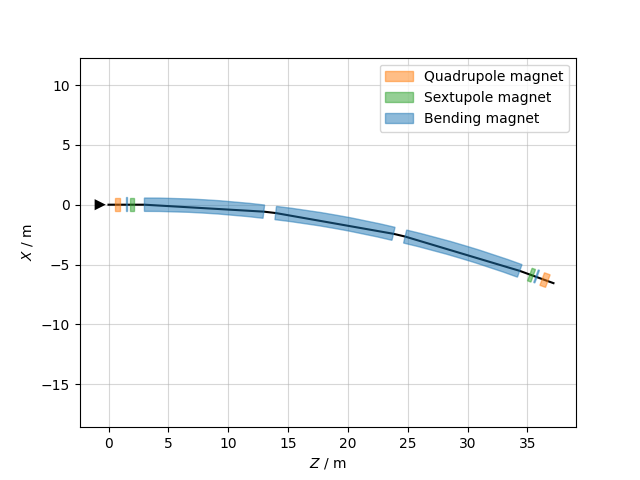

In [8]:
halfcell.survey().plot()

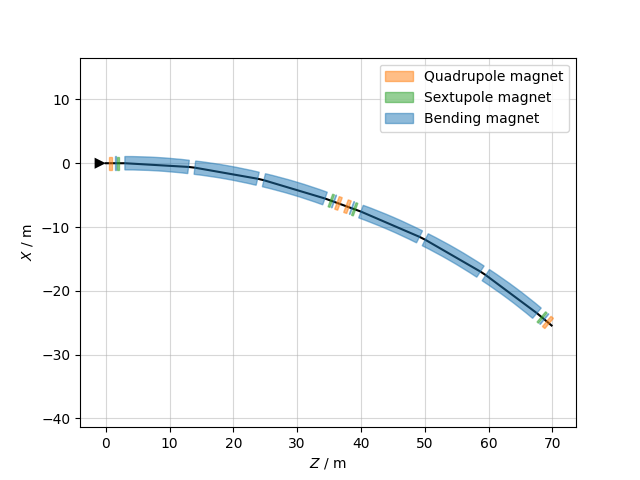

In [9]:
# Build full fodo cell
hcell_left = halfcell.replicate(name='l', mirror=True)
hcell_right = halfcell.replicate(name='r')

cell = env.new_line(components=[
    env.new('start', xt.Marker),
    hcell_left,
    hcell_right,
    env.new('end', xt.Marker),
])
cell.survey().plot()

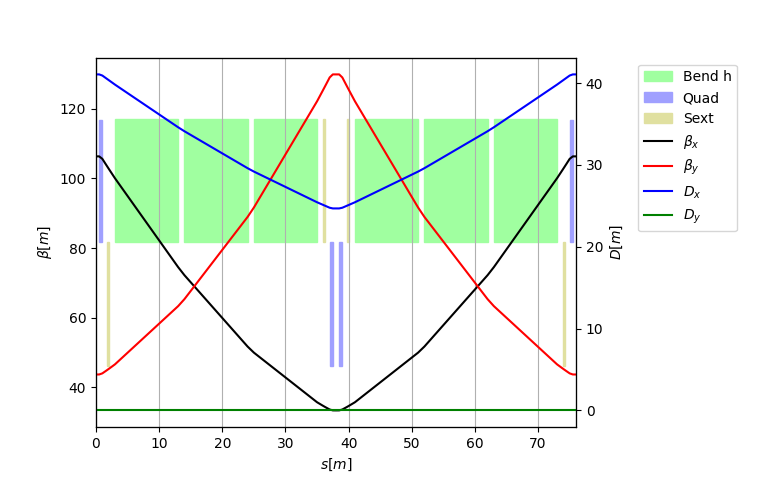

In [10]:
# Twiss cell
cell.twiss4d().plot()

In [11]:
# March phase advance
opt = cell.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kqf', 'kqd'], step=1e-5),
    targets=xt.TargetSet(
        qx=0.333333,
        qy=0.333333,
    ))

print('Before match:')
opt.target_status()

opt.solve()

print('After match:')
opt.target_status()

print('\nMatch history')
opt.log()

Before match:el call n. 0               
Target status:                          
id tag state description                              tol_met       residue   current_val    target_val
 0     ON    'qx', val=0.333333, tol=1e-09, weight=10   False      -0.12073      0.212603      0.333333
 1     ON    'qy', val=0.333333, tol=1e-09, weight=10   False     -0.165044      0.168289      0.333333
Matching: model call n. 21               

After match:
Target status:                           
id tag state description                              tol_met       residue   current_val    target_val
 0     ON    'qx', val=0.333333, tol=1e-09, weight=10    True   1.87184e-10      0.333333      0.333333
 1     ON    'qy', val=0.333333, tol=1e-09, weight=10    True  -8.84909e-11      0.333333      0.333333

Match history


Table: 6 rows, 14 cols
iteration       penalty alpha tag tol_met target_active hit_limits vary_active        vary_0 ...
        0       2.04487    -1     nn      yy            nn         yy                  0.027
        1      0.916771     0     nn      yy            nn         yy              0.0486713
        2       0.18993     0     nn      yy            nn         yy              0.0447389
        3    0.00758958     0     nn      yy            nn         yy              0.0433639
        4   1.28723e-05     0     nn      yy            nn         yy               0.043302
        5   2.07047e-09     0     yy      yy            nn         yy              0.0433019

In [12]:
# Twiss after match
tw_cell = cell.twiss4d()

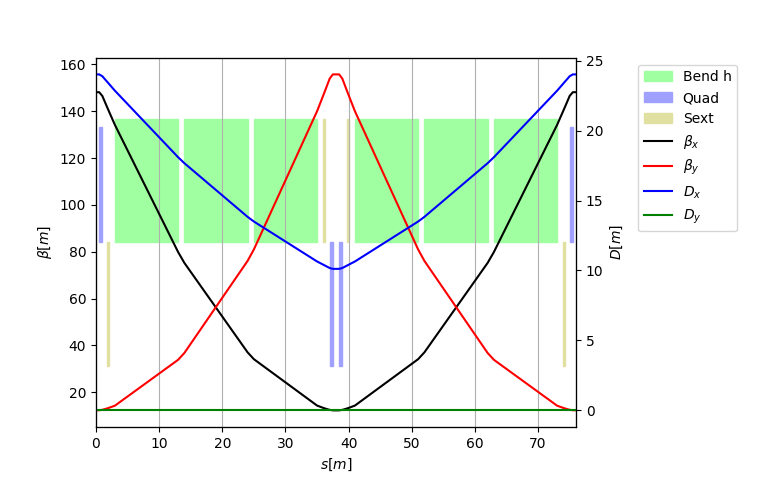

In [13]:
tw_cell.plot()

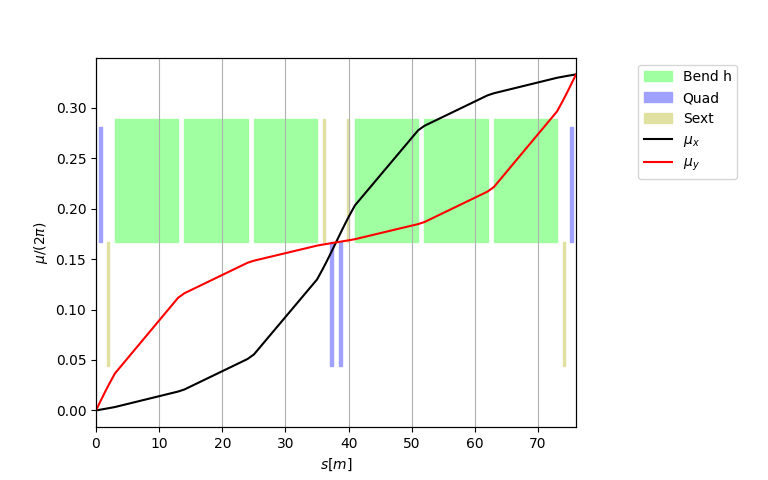

In [14]:
tw_cell.plot('mux muy')

## Straight section cell

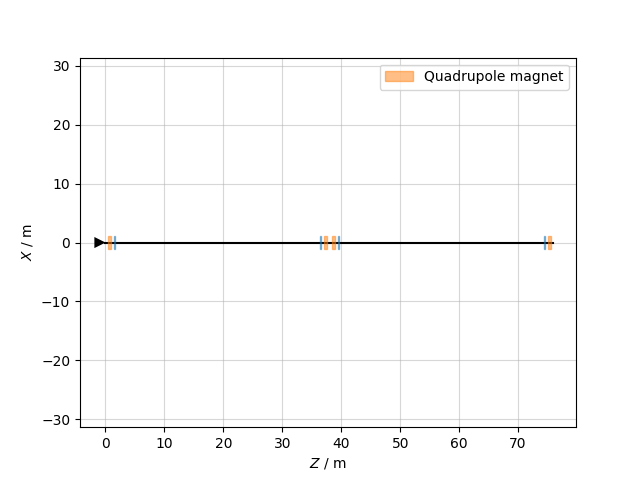

In [15]:
env.vars({
    'kqf.ss': 0.027 / 2,
    'kqd.ss': -0.0271 / 2,
})

halfcell_ss = env.new_line(components=[
    env.new('mid', xt.Marker, at='l.halfcell'),
    env.new('mq.ss.d', 'mq', k1='kqd.ss', at = '0.5 + l.mq / 2'),
    env.new('mq.ss.f', 'mq', k1='kqf.ss', at = 'l.halfcell - l.mq / 2 - 0.5'),
    env.new('corrector.ss.v', 'corrector', at=0.75, from_='mq.ss.d'),
    env.new('corrector.ss.h', 'corrector', at=-0.75, from_='mq.ss.f')
])

hcell_left_ss = halfcell_ss.replicate(name='l', mirror=True)
hcell_right_ss = halfcell_ss.replicate(name='r')
cell_ss = env.new_line(components=[
    env.new('start.ss', xt.Marker),
    hcell_left_ss,
    hcell_right_ss,
    env.new('end.ss', xt.Marker),
])

cell_ss.survey().plot()

In [16]:
# March to the same betas as the edge of the arc cell
opt = cell_ss.match(
    method='4d',
    vary=xt.VaryList(['kqf.ss', 'kqd.ss'], step=1e-5),
    targets=xt.TargetSet(
        betx=tw_cell.betx[-1], bety=tw_cell.bety[-1], at='start.ss',
    ))

Matching: model call n. 32               



## Assemble a ring

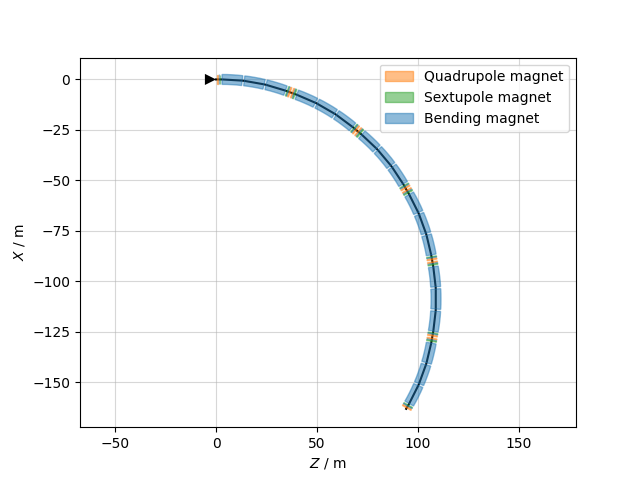

In [17]:
arc = env.new_line(components=[
    cell.replicate(name='cell.1'),
    cell.replicate(name='cell.2'),
    cell.replicate(name='cell.3'),
])
arc.survey().plot()

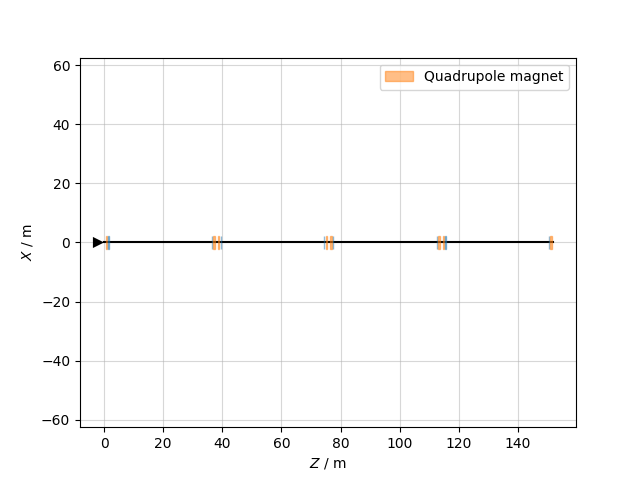

In [18]:
straight_section = env.new_line(components=[
    cell_ss.replicate('cell.1'),
    cell_ss.replicate('cell.2'),
])
straight_section.survey().plot()

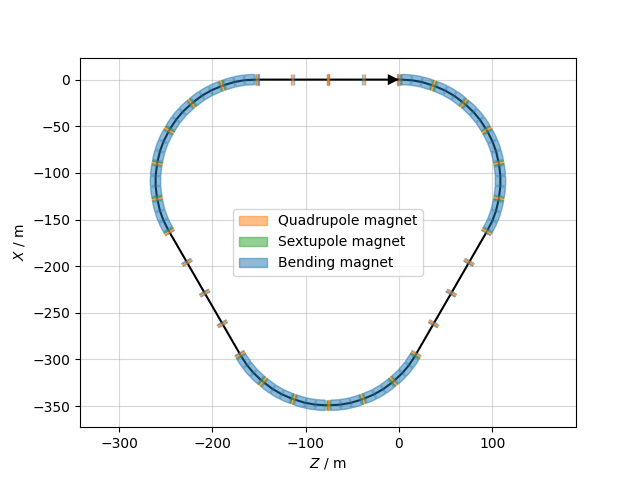

In [19]:
ring = env.new_line(components=[
    arc.replicate(name='arc.1'),
    straight_section.replicate(name='ss.1'),
    arc.replicate(name='arc.2'),
    straight_section.replicate(name='ss.2'),
    arc.replicate(name='arc.3'),
    straight_section.replicate(name='ss.3'),
])

ring.survey().plot()


# Inspect optics

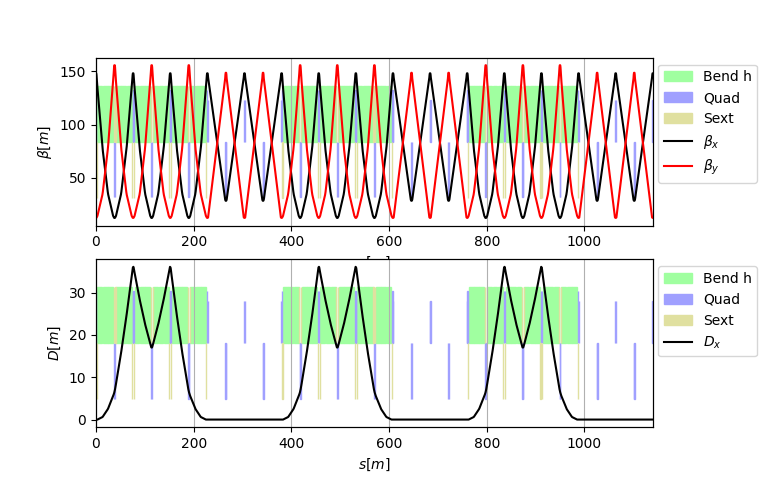

In [20]:
tw = ring.twiss4d()
fig = plt.figure(figsize=(6.4*1.2, 4.8))
ax1 = fig.add_subplot(2, 1, 1)
pltbet = tw.plot('betx bety', ax=ax1)

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
pltdx = tw.plot('dx', ax=ax2)

fig.subplots_adjust(right=.85)
pltbet.move_legend(1.2,1)
pltdx.move_legend(1.2,1)

## Build and insertion

We want 40 m of free space with round betas to install an experiment

In [21]:
env.vars({
    'k1.q1': 0.025,
    'k1.q2': -0.025,
    'k1.q3': 0.025,
    'k1.q4': -0.02,
    'k1.q5': 0.025,
})
env.new('mq.1', 'mq', k1='k1.q1')

half_insertion = env.new_line(components=[

    # Start-end markers
    env.new('ip', xt.Marker),
    env.new('e.insertion', xt.Marker, at=76), # Same insertion length as initial straight

    # Quads
    env.new('mq.1', 'mq', k1='k1.q1', at = 20),
    env.new('mq.2', 'mq', k1='k1.q2', at = 25),
    env.new('mq.3', 'mq', k1='k1.q3', at=37),
    env.new('mq.4', 'mq', k1='k1.q4', at=55),
    env.new('mq.5', 'mq', k1='k1.q5', at=73),

    # Dipole correctors (will use h and v on the same corrector)
    env.new('corrector.ss.1', 'corrector', at=0.75, from_='mq.1'),
    env.new('corrector.ss.2', 'corrector', at=-0.75, from_='mq.2'),
    env.new('corrector.ss.3', 'corrector', at=0.75, from_='mq.3'),
    env.new('corrector.ss.4', 'corrector', at=-0.75, from_='mq.4'),
    env.new('corrector.ss.5', 'corrector', at=0.75, from_='mq.5'),

])

In [22]:
# Match the optics of the insertion
tw_arc = arc.twiss4d()

opt = half_insertion.match(
    solve=False,
    betx=tw_arc.betx[0], bety=tw_arc.bety[0],
    alfx=tw_arc.alfx[0], alfy=tw_arc.alfy[0],
    init_at='e.insertion',
    start='ip', end='e.insertion',
    vary=xt.VaryList(['k1.q1', 'k1.q2', 'k1.q3', 'k1.q4', 'k1.q5'], step=1e-5),
    targets=[
        xt.TargetSet(alfx=0, alfy=0, at='ip'),
        xt.Target(lambda tw: tw['betx', 'ip'] - tw['bety', 'ip'], 0),
        xt.Target(lambda tw: tw.betx.max(), xt.LessThan(400)),
        xt.Target(lambda tw: tw.bety.max(), xt.LessThan(400)),
        xt.Target(lambda tw: tw.betx.min(), xt.GreaterThan(2)),
        xt.Target(lambda tw: tw.bety.min(), xt.GreaterThan(2)),
    ]
)
opt.step(40)
opt.solve()

Matching: model call n. 66               



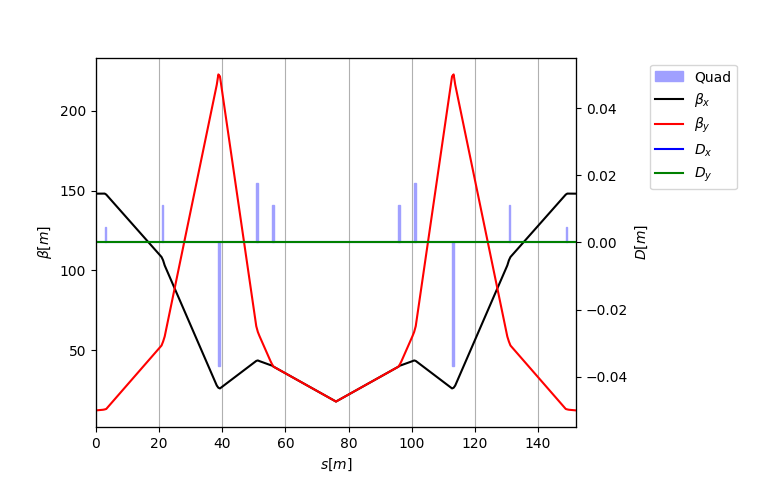

In [23]:
insertion = env.new_line([
    half_insertion.replicate('l', mirror=True),
    half_insertion.replicate('r')])

insertion.twiss4d().plot()

## Build a ring wih the insertion

In [24]:
ring_2 = env.new_line(components=[
    arc.replicate(name='r2.arc.1'),
    straight_section.replicate(name='r2.ss.2'),
    arc.replicate(name='r2.arc.2'),
    insertion,
    arc.replicate(name='r2.arc.3'),
    straight_section.replicate(name='r2.ss.3')
])

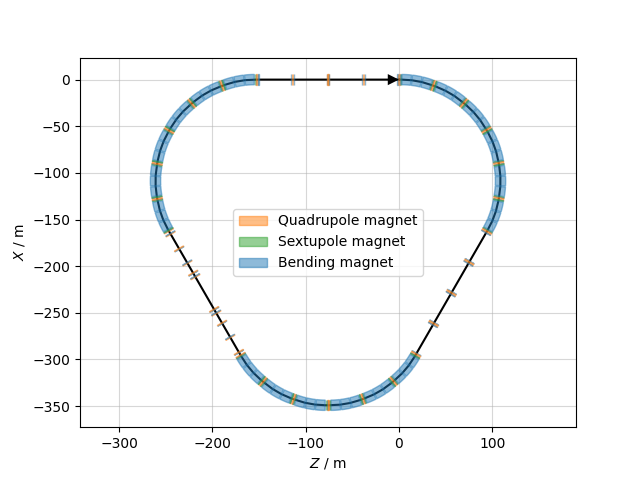

In [25]:
ring_2.survey().plot()

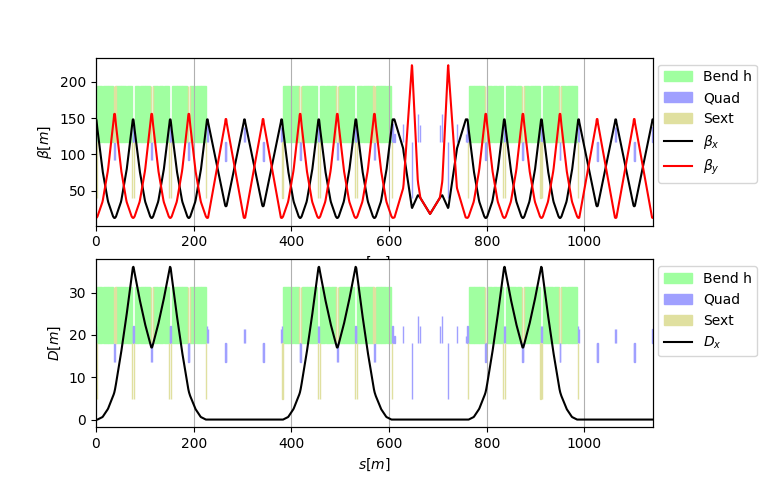

In [26]:
tw = ring_2.twiss4d()
fig = plt.figure(figsize=(6.4*1.2, 4.8))
ax1 = fig.add_subplot(2, 1, 1)
pltbet = tw.plot('betx bety', ax=ax1)

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
pltdx = tw.plot('dx', ax=ax2)

fig.subplots_adjust(right=.85)
pltbet.move_legend(1.2,1)
pltdx.move_legend(1.2,1)

In [27]:
# Make a shallow copy a and slice to get optics every 0.5 m
ring_2_sliced = ring_2.select()
ring_2_sliced.cut_at_s(np.arange(0, ring_2.get_length(), 0.5))

Slicing line:   0%|          | 0/512 [00:00<?, ?it/s]

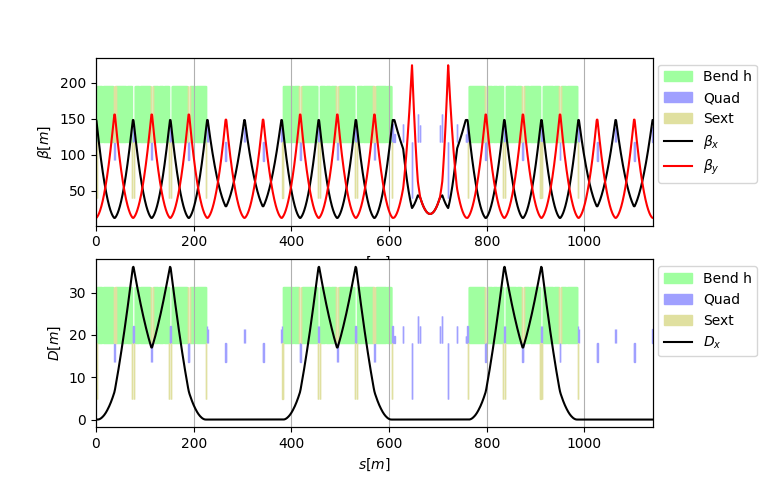

In [28]:
tw = ring_2_sliced.twiss4d()
fig = plt.figure(figsize=(6.4*1.2, 4.8))
ax1 = fig.add_subplot(2, 1, 1)
pltbet = tw.plot('betx bety', ax=ax1)

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
pltdx = tw.plot('dx', ax=ax2)

fig.subplots_adjust(right=.85)
pltbet.move_legend(1.2,1)
pltdx.move_legend(1.2,1)

In [29]:
1/np.sqrt(tw.momentum_compaction_factor)

np.float64(3.3656581598716144)

In [30]:
tw.qx

np.float64(4.384558972911101)